# Base model

#### **Implementation Notes**

In this notebook we implement our base model, with the objective of estimating transmission rates for $P$ settings given a sample of $N$ observations. In particular, this model assumes that:

- Random sampling.
- Perfect antigen tests, implying no false positive/negative results.

These assumptions are relaxed in subsequent models.

In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import stan

In [2]:
# Parameters
P = 10
N = 10 ** 4
SEED = 1729

In [3]:
# Ground truth
np.random.seed(SEED)
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)
base_rate = np.random.beta(2, 10, 1)

In [4]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * \
        np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)
X = X.loc[:, X.columns.str.startswith('O')]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      10000 non-null  int64
 1   O2      10000 non-null  int64
 2   O3      10000 non-null  int64
 3   O4      10000 non-null  int64
 4   O5      10000 non-null  int64
 5   O6      10000 non-null  int64
 6   O7      10000 non-null  int64
 7   O8      10000 non-null  int64
 8   O9      10000 non-null  int64
 9   O10     10000 non-null  int64
dtypes: int64(10)
memory usage: 781.4 KB


In [5]:
# Create model
sm = pystan.StanModel(model_name='base_model', model_code="""
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
}
model {
  // Precomputation
  real log1m_theta[P];
  real log1m_rho;
  
  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }

  log1m_rho = log1m(rho);
    
  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  
  // Likelihood
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    
    if (y[n] == 1) {
      target += log1m_exp(s);
    } 
    else {
      target += s;
    }
  }
}
""")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL tt_mod_f96712c59d75ae7aed2d9af826f16a3b NOW.


In [6]:
# Set NUTS parameters
nuts_samples = 1000
nuts_burnin = 500
nuts_chains = 16

In [7]:
# Fit model
start = time.time()
model_data = {'N': N, 'P': P, 'X': X.to_numpy(), 'y': y.to_numpy()}
fit = sm.sampling(
    data=model_data,
    iter=nuts_samples,
    warmup=nuts_burnin,
    chains=nuts_chains
)
print(f"{time.time() - start:.02f} seconds elapsed")

293.00 seconds elapsed


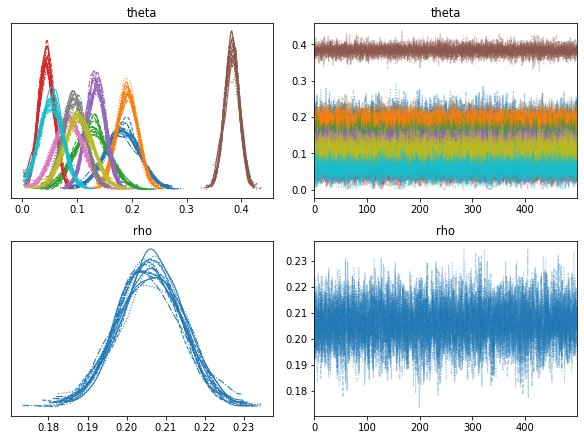

In [8]:
# Evaluate fit
arviz.plot_trace(fit, figsize=(8, 6));

In [9]:
# View results
print("Inference on fitted model:")
print(fit)
print('')
print('Ground truth:')
print(true_transmission_rate)
print(base_rate)

Inference on fitted model:
Inference for Stan model: tt_mod_f96712c59d75ae7aed2d9af826f16a3b.
16 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    0.18  3.5e-4   0.03   0.12   0.16   0.18    0.2   0.24   8061    1.0
theta[2]    0.19  2.1e-4   0.02   0.15   0.18   0.19    0.2   0.23   8233    1.0
theta[3]    0.13  3.2e-4   0.03   0.07   0.11   0.13   0.15   0.19   8432    1.0
theta[4]    0.04  1.9e-4   0.01   0.02   0.03   0.04   0.05   0.07   6118    1.0
theta[5]    0.13  2.0e-4   0.02    0.1   0.12   0.13   0.15   0.17   7450    1.0
theta[6]    0.38  1.5e-4   0.01   0.36   0.37   0.38   0.39   0.41   8419    1.0
theta[7]    0.08  3.3e-4   0.03   0.03   0.07   0.08    0.1   0.14   6675    1.0
theta[8]    0.09  2.5e-4   0.02   0.05   0.08   0.09   0.11   0.14   7248    1.0
theta[9]     0.1  3.1e-4   0.03   0.05   0.09    0.1   0.12 